In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
import matplotlib.patches as mpatches

In [27]:
set2_colors = sns.color_palette("Set2", 7)
set2_colors_map = {
    "SEKER":    set2_colors[0], # cyan
    "BARBUNYA": set2_colors[1], # orange
    "BOMBAY":   set2_colors[2], # purple
    "CALI":     set2_colors[3], # pink
    "HOROZ":    set2_colors[4], # green
    "SIRA":     set2_colors[5], # yellow
    "DERMASON": set2_colors[6]  # grey
}

In [28]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from scipy.optimize import linear_sum_assignment


le = LabelEncoder()
y_num = le.fit_transform(y)          # 0..6
K = len(le.classes_)

def align_to_true(y_true_num, y_pred, n_classes):
    cm = confusion_matrix(y_true_num, y_pred, labels=np.arange(n_classes))
    r, c = linear_sum_assignment(-cm)               # maximize matches
    mapping = {pred: true for true, pred in zip(r, c)}
    return np.vectorize(mapping.get)(y_pred)

def labels_to_colors(aligned_num_labels):
    class_names = le.inverse_transform(aligned_num_labels)      # -> ['SEKER', ...]
    return pd.Series(class_names).map(set2_colors_map).to_numpy()


# Models
models = {
    "K-Means": KMeans(n_clusters=7, random_state=0),
    "GMM": GaussianMixture(n_components=K, covariance_type="full", random_state=0),
    "Spectral": SpectralClustering(
        n_clusters=K, affinity="nearest_neighbors", n_neighbors=10,
        assign_labels="kmeans", random_state=0, n_jobs=-1
    ),
}

out = {}
for name, model in models.items():
    pred = model.fit_predict(X_scaled)
    ari = adjusted_rand_score(y, pred)
    nmi = normalized_mutual_info_score(y, pred)
    out[name] = (pred, ari, nmi)
    print(f"{name:8s} - ARI: {ari:.4f}, NMI: {nmi:.4f}")

/Users/angelye/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-Means  - ARI: 0.6689, NMI: 0.7140
GMM      - ARI: 0.6075, NMI: 0.7224
Spectral - ARI: 0.6313, NMI: 0.7287


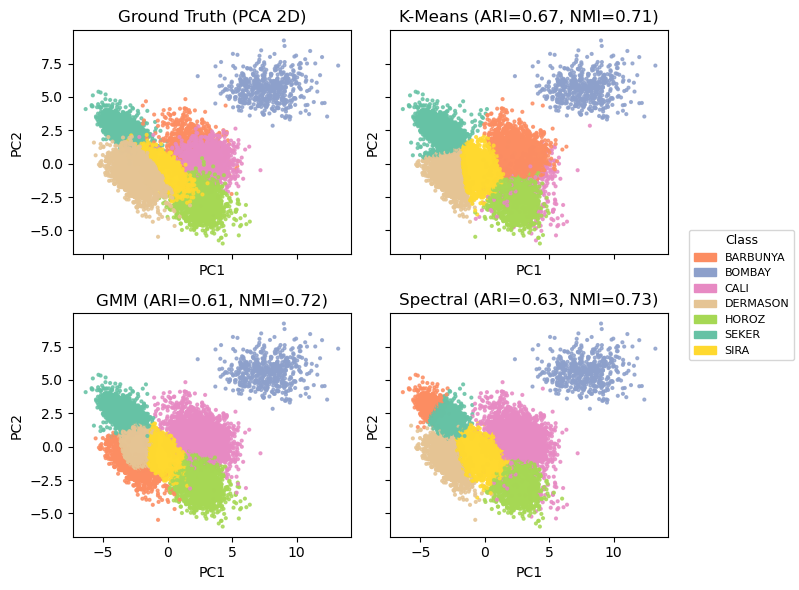

In [31]:
# Plot
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
axes = axes.ravel()

# legend once for the whole figure
handles = [mpatches.Patch(color=set2_colors_map[cls], label=cls) for cls in le.classes_]
fig.legend(handles=handles, title="Class", loc="center right", fontsize=8, title_fontsize=9)

# (0) Ground Truth
gt_colors = y.map(set2_colors_map).to_numpy()
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=gt_colors, s=4, alpha=0.8)
axes[0].set_title("Ground Truth (PCA 2D)")

# (1)(2)(3) Clusterings (aligned)
for ax, (name, (pred, ari, nmi)) in zip(axes[1:], out.items()):
    pred_aligned = align_to_true(y_num, pred, K)
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_to_colors(pred_aligned), s=4, alpha=0.8)
    ax.set_title(f"{name} (ARI={ari:.2f}, NMI={nmi:.2f})")

for ax in axes:
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

plt.tight_layout(rect=[0, 0, 0.86, 1])  # leave space for legend on the right
plt.show()
